## Sentiment Analysis from Reddit Wallstreetbets

In [1]:
!pip install praw

In [2]:
import praw #Python Reddit API wrapper
import pandas as pd
import datetime as dt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /opt/conda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Create a reddit connection with reddit API information
# Create praw.Reddit object with with reddit OAuth creds
# Reddit application creds created at https://www.reddit.com/prefs/apps
reddit = praw.Reddit(
            client_id='',
            client_secret='',
            user_agent='mads_capstone')

In [4]:
print(reddit.user.me())

None


In [5]:
# Get date as a date object
def get_date(date):
    return dt.datetime.fromtimestamp(date)

# 
# Get all comments leaving the first one out, which mostly contains metadata
# 
def get_comments_dict_by_id(id, ticker):
    post = reddit.submission(id=id)
    # store all comments scraped from submission object in a dict
    comments_dict = {
                "comment_id" : [],
                "submit_time" : [],
                "comment_body" : []
            }
    stock = ticker
    post.comments.replace_more(limit=None)
    for comments in post.comments.list():
        if any(keyword in comments.body for keyword in stock):
            if ('**User Report**' not in comments.body): #Ignore the comment containing user report stats
                comments_dict['comment_id'].append(comments.id)
                comments_dict['submit_time'].append(get_date(comments.created_utc))
                comments_dict['comment_body'].append(comments.body)        
    return comments_dict

# Obtain the 100 'hottest' submissions in r/WallStreetbets that mentions 'TSLA'
subreddit = reddit.subreddit('WallStreetBets')
ticker = "TSLA"
posts = []

# Create an empty dataframe
combined_df=pd.DataFrame()

# Get the hottest posts in a dataframe
for post in subreddit.search(ticker, sort='hot',limit=100):
    if post.domain != "self.wallstreetbets":
        continue
    # Get individual comments within each of these hot posts as a dictionary
    comments =  get_comments_dict_by_id(post.id, ticker)
    # Create a datframe from the dictionary
    comments_df = pd.DataFrame.from_dict(comments)
     # Add these comments to the dataframe
    combined_df=combined_df.append(comments_df,ignore_index=True)
    posts.append([post.title, post.score, post.id, post.url, post.num_comments, post.selftext, \
                  get_date(post.created_utc)])

posts_df = pd.DataFrame(posts,columns=['title', 'score', 'id', 'url', 'num_comments', 'body', 'created'])

## Add these high level posts to the combined_df also, after renaming the columns
posts_to_comments_df = posts_df[['id', 'created', 'title', 'body']]
posts_to_comments_df['comment_body'] = posts_to_comments_df['title'] + " " + posts_to_comments_df['body']
posts_to_comments_df = posts_to_comments_df.drop(['title', 'body'], axis=1)
posts_to_comments_df.rename({'id': 'comment_id', 
           'created': 'submit_time'}, 
          axis = "columns", inplace = True)
combined_df=combined_df.append(posts_to_comments_df,ignore_index=True)

In [6]:
# Define new words and add to Vader lexicon
# https://www.stash.com/learn/stashs-guide-to-reddits-wallstreetbets-can-help-you-understand-the-lingo/
    
wsb_lexicon = {
    'moon': 3,
    'buy': 3,
    'buying': 3,
    'long': 3,
    'tendies': 3,
    'diamond': 3,
    'btfd': 3,
    'dd': 3,
    'pump': 3,
    'rocket': 3,
    'lambo': 3,
    'locked': 3,
    'loaded': 3,
    'rebound': 1,
    'massive': 1,
    'hawkish': 2,
    'citadel': 2,
    'bounce': 2,
    'hold': 2,
    'holding': 2,
    'call': 3,
    'calls': 3,
    'squeeze': 3,
    'gain': 2,
    'gains': 2,
    'liquidate': -3,
    'liquidated': -3,
    'put': -3,
    'puts': -3,
    'bagholder': -3,
    'bagholders': -3,
    'short': -3,
    'shorts': -3,
    'sell': -3,
    'paper': -3,
    'dump': -3,
    'yolo': 2,
    'guh':-3,
    '🐂': 3,
    '🍗': 3,
    '🚀🌝': 3,
    '💎':3,
    '😂': 3,
    '💎🤲':3,
    '🚀': 3,
    '🧸': -3,
    '🧻🤲': -3,
    '😢': -3
}

# Initialise vader sentiment analyser
vader_sia = SentimentIntensityAnalyzer()
vader_sia.lexicon.update(wsb_lexicon)

In [7]:
# Iterate through the comments and get the polarity scores using vader
scores = combined_df['comment_body'].apply(vader_sia.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the comments and the list of dicts
combined_df = combined_df.join(scores_df, rsuffix='_right')


In [8]:
# Posts include all the hot posts 
posts_df.head(10)

,title,score,id,url,num_comments,body,created
0,TSLA Calls vanquished my last hope. Had $1k 24...,570,1552yul,https://www.reddit.com/r/wallstreetbets/commen...,507,"&#x200B;\n\n[Was up to 14.5k by end of March, ...",2023-07-20 20:54:33
1,Is TSLA going to repeat history,28,155d46n,https://www.reddit.com/r/wallstreetbets/commen...,61,"Yes, I am well aware that the past does not pr...",2023-07-21 04:17:52
2,$TSLA Bulls Screamed GrEeN DaY after I called ...,179,154t2k6,https://www.reddit.com/r/wallstreetbets/commen...,143,290p Post for context: [https://www.reddit.com...,2023-07-20 14:51:10
3,7/21 $272.5 TSLA CALLS,49,154uwhl,https://www.reddit.com/r/wallstreetbets/commen...,42,I started my adventure with a total of 1.5k (d...,2023-07-20 15:57:52
4,Oh TSLA what have you done…,582,154fhms,https://www.reddit.com/r/wallstreetbets/commen...,371,I was so sure that TSLA would break $300…. It ...,2023-07-20 03:19:42
5,So I was just listening to the entirety of the...,155,1549l5i,https://www.reddit.com/r/wallstreetbets/commen...,239,There was one point in the second time (I beli...,2023-07-19 22:50:33
6,$TSLA $300 -> $270 MINIMUM.. Cybertruck Produc...,80,154dd12,https://www.reddit.com/r/wallstreetbets/commen...,135,Entered $290p at the $300 rejection level toda...,2023-07-20 01:39:11
7,TSLA fall,0,154opmn,https://www.reddit.com/r/wallstreetbets/commen...,98,Did nobody consider how overvalued TSLA was pr...,2023-07-20 11:48:20
8,$TSLA inverse...?,94,152k0yj,https://www.reddit.com/r/wallstreetbets/commen...,145,So let me get this straight…\n\nThe sentiment ...,2023-07-18 01:12:36
9,What's the sentiment towards TSLA Earning?,32,1519seq,https://www.reddit.com/r/wallstreetbets/commen...,77,Degens\n\nKing TSLA earnings are 3 days away.\...,2023-07-16 15:56:48


In [9]:
# Combined_df includes all the underlying comments that are part of the hot posts
combined_df.head(10)

,comment_id,submit_time,comment_body,neg,neu,pos,compound
0,jss7foe,2023-07-20 21:15:42,"You’re 24, now was the time to make this mista...",0.086,0.700,0.213,0.9299
1,jss78hl,2023-07-20 21:14:24,Loss porn is so much better when you can tell ...,0.118,0.719,0.163,0.2212
2,jssbltk,2023-07-20 21:42:44,Your Stage 1 training is now complete. Now you...,0.000,1.000,0.000,0.0000
3,jssbphh,2023-07-20 21:43:25,"Classic delusional thinking with the coulda, w...",0.178,0.727,0.095,-0.5574
4,jssawci,2023-07-20 21:38:06,"This shit makes me hard, thanks OP",0.420,0.336,0.244,-0.2732
5,jssghg4,2023-07-20 22:15:26,“Trying to regain my wealth” 😂\n\nYou never ha...,0.131,0.745,0.124,-0.0330
6,jssfc6r,2023-07-20 22:07:38,That’s it 7k? Please get in the back of the bu...,0.000,0.827,0.173,0.3182
7,jssi5kj,2023-07-20 22:26:58,"Graph is amazing. Straight down, one lucky hit...",0.158,0.561,0.281,0.5719
8,jss4y66,2023-07-20 20:59:43,This is a casino.,0.000,1.000,0.000,0.0000
9,jss8fm9,2023-07-20 21:22:06,"You’re 24 and it’s less than 10k, your life is...",0.088,0.806,0.106,0.3729


In [10]:
def get_mean_scores(df, group_by_col):
    # Group by date and calculate the mean
    mean_scores = df.groupby(pd.Grouper(key=group_by_col, axis=0, 
                          freq='1D', sort=True)).mean()

    # Unstack the mean_scores 
    mean_scores = mean_scores.unstack()

    # Get the cross-section of compound sentiment score
    mean_scores = mean_scores.xs('compound').transpose()
    
    res_df= mean_scores.to_frame().reset_index()
    res_df = res_df.rename(columns= {group_by_col: 'Date', 0: 'score'})
    res_df = res_df.ffill()
    return res_df

df1 = get_mean_scores(combined_df, 'submit_time')
df1

,Date,score
0,2023-06-27,0.373836
1,2023-06-28,0.310728
2,2023-06-29,0.227200
3,2023-06-30,0.398856
4,2023-07-01,0.126655
5,2023-07-02,0.180073
6,2023-07-03,0.305950
7,2023-07-04,0.012231
8,2023-07-05,0.107078
9,2023-07-06,0.154062


In [11]:
# Group by date and calculate the mean
mean_scores = combined_df.groupby(pd.Grouper(key='submit_time', axis=0, 
                      freq='1D', sort=True)).mean()

# Unstack the mean_scores 
mean_scores = mean_scores.unstack()

# Get the cross-section of compound sentiment score
mean_scores = mean_scores.xs('compound').transpose()

In [12]:
df1 = mean_scores.to_frame().reset_index()
df1 = df1.rename(columns= {'submit_time': 'Date', 0: 'score'})
df1

,Date,score
0,2023-06-27,0.373836
1,2023-06-28,0.310728
2,2023-06-29,0.227200
3,2023-06-30,0.398856
4,2023-07-01,0.126655
5,2023-07-02,0.180073
6,2023-07-03,0.305950
7,2023-07-04,0.012231
8,2023-07-05,0.107078
9,2023-07-06,0.154062


In [13]:
!pip install yfinance

     |████████████████████████████████| 62 kB 7.9 MB/s  eta 0:00:01
     |████████████████████████████████| 101 kB 33.5 MB/s ta 0:00:01
     |████████████████████████████████| 142 kB 56.3 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 8.4 MB/s s eta 0:00:01
     |████████████████████████████████| 7.4 MB 100.5 MB/s eta 0:00:01
     |████████████████████████████████| 502 kB 113.8 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 123.2 MB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 76.3 MB/s eta 0:00:01
     |████████████████████████████████| 175 kB 103.9 MB/s eta 0:00:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2021.1
    Uninstalling pytz-2021.1:
      Successfully uninstalled pytz-2021.1
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: pandas
    Found existing installation: pa

In [14]:
def get_stock_returns(ticker = 'TSLA', startDate = '2023-06-15', endDate = '2023-07-23'):
    # importing the yfinance package
    import yfinance as yf
    import numpy as np

    # downloading the data of the ticker value between
    # the start and end dates
    resultData = yf.download(ticker, startDate, endDate)

    df = resultData.reset_index()

    df['pct_change'] = df['Adj Close'].pct_change()
    df['log_ret'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(1))
    
    df = df[['Date', 'Adj Close', 'log_ret']]
    return df

df2 = get_stock_returns()

[*********************100%***********************]  1 of 1 completed


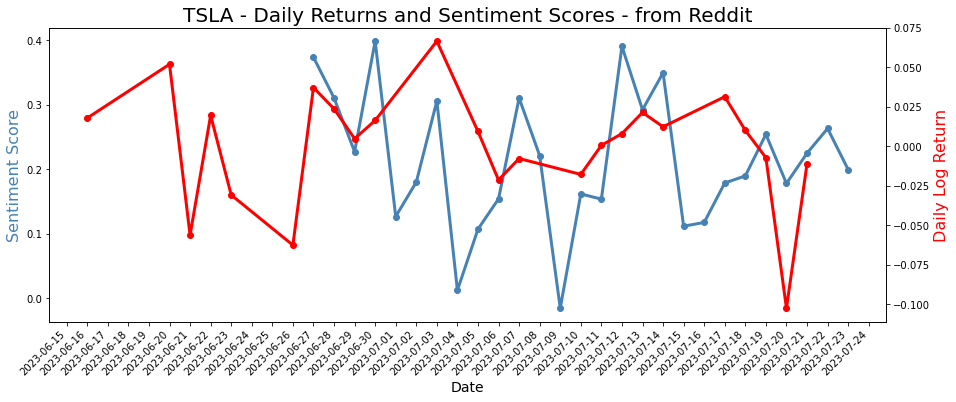

In [15]:
def plot_sentiment_graph(title, score_df, ret_df, int_in_days=1, mark = 'o', width = 3):
    import matplotlib.pyplot as plt
    from matplotlib import dates

    #define colors to use
    col1 = 'steelblue'
    col2 = 'red'

    #define subplots
    fig,ax = plt.subplots(figsize=(15,6))

    #add first line to plot
    ax.plot(score_df.Date, score_df.score, color=col1, marker=mark, linewidth=width)

    #add x-axis label
    ax.set_xlabel('Date', fontsize=14)

    #add y-axis label
    ax.set_ylabel('Sentiment Score', color=col1, fontsize=16)

    #define second y-axis that shares x-axis with current plot
    ax2 = ax.twinx()

    #add second line to plot
    ax2.plot(ret_df.Date, ret_df.log_ret, color=col2, marker=mark, linewidth=width)

    #add second y-axis label
    ax2.set_ylabel('Daily Log Return', color=col2, fontsize=16)

    formatter = dates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(formatter)
    plt.gcf().autofmt_xdate(rotation=45)
    ax.xaxis.set_major_locator(dates.DayLocator(interval=int_in_days))

    # displaying the title
    plt.title(title, fontsize=20)

    plt.show()    

plot_sentiment_graph("TSLA - Daily Returns and Sentiment Scores - from Reddit", df1, df2, 1)

## Sentiment Analysis from News

In [16]:
from datetime import date, datetime, timedelta

def get_last_date_of_month(year, month):   
    if month == 12:
        last_date = datetime(year, month, 31)
    else:
        last_date = datetime(year, month + 1, 1) + timedelta(days=-1)    
    return last_date.strftime("%Y-%m-%d")

def get_news_from_eodhistoricaldata():
    from os.path import exists
    import urllib, json

    ticker='TSLA.US'
    frm = '2018-01-01'
    to = "2023-07-23"
    api_token = ""
    file = "news.json"
    
    file_exists = exists(file)
    
    result = list()
    
    if (file_exists):
        # JSON file
        f = open (file, "r")  
        # Reading from file
        result = json.loads(f.read())
    else:
        for year in range(2018,2024):
            for mon in range(1,13):
                frm = str(year) + "-" + "{:02d}".format(mon) + "-01"
                to = get_last_date_of_month(year, mon)
                file = "news_"+ str(year) + "-" + "{:02d}".format(mon)

                url = "https://eodhistoricaldata.com/api/news?api_token=" + api_token + "&s=" + ticker + \
            "&offset=0&from=" + frm + "&to=" + to + "&limit=1000&fmt=json"
                print(file + ": " + url)

                response = urllib.request.urlopen(url)
                data = json.loads(response.read())
                result.extend(data)

        with open("news.json", "w") as outfile:
            json.dump(result, outfile)
    
    return result


result = get_news_from_eodhistoricaldata()

In [17]:
import pandas as pd
news_df = pd.json_normalize(result)

In [18]:
print(news_df.shape)
news_df.head(10)

(25571, 11)


,date,title,content,link,symbols,tags,sentiment.polarity,sentiment.neg,sentiment.neu,sentiment.pos,sentiment
0,2018-01-23T08:30:00+00:00,Tesla Announces New Long-Term Performance Awar...,Compensation is Tied to Market Capitalization ...,https://www.globenewswire.com/news-release/201...,[TSLA.US],"[INC, NASDAQ:TSLA, TESLA]",1.000,0.016,0.832,0.153,NaN
1,2018-01-03T21:22:00+00:00,Tesla Q4 2017 Vehicle Production and Deliveries,"PALO ALTO, Calif., Jan. 03, 2018 (GLOBE NEWS...",https://www.globenewswire.com/news-release/201...,[TSLA.US],"[INC, NASDAQ:TSLA, TESLA]",0.994,0.012,0.887,0.101,NaN
2,2018-02-07T21:06:00+00:00,Tesla Releases Fourth Quarter and Full Year 20...,"PALO ALTO, Calif., Feb. 07, 2018 (GLOBE NEWS...",https://www.globenewswire.com/news-release/201...,[TSLA.US],"[INC, NASDAQ:TSLA, TESLA]",0.318,0.000,0.980,0.020,NaN
3,2018-02-05T12:50:00+00:00,"Recent Analysis Shows Allegiant Travel, Green,...","NEW YORK, Feb. 05, 2018 (GLOBE NEWSWIRE) -- ...",https://www.globenewswire.com/news-release/201...,"[ALGT.US, FISI.US, GNBC.US, NAVI.US, TSLA.US, ...",[FUNDAMENTAL MARKETS],0.997,0.008,0.928,0.064,NaN
4,2018-04-19T11:00:00+00:00,Tesla Announces Date for First Quarter 2018 Fi...,"PALO ALTO, Calif., April 19, 2018 (GLOBE NEW...",https://www.globenewswire.com/news-release/201...,[TSLA.US],"[INC, NASDAQ:TSLA, TESLA]",0.318,0.000,0.983,0.017,NaN
5,2018-04-16T12:20:00+00:00,"New Research Coverage Highlights Aradigm, Ultr...","NEW YORK, April 16, 2018 (GLOBE NEWSWIRE) --...",https://www.globenewswire.com/news-release/201...,"[ARDM.US, FNSR.US, PGR.US, TPH.US, TSLA.US, UP...",[FUNDAMENTAL MARKETS],0.995,0.009,0.937,0.054,NaN
6,2018-04-03T13:06:00+00:00,Tesla Q1 2018 Vehicle Production and Deliveries,"PALO ALTO, Calif., April 03, 2018 (GLOBE NEW...",https://www.globenewswire.com/news-release/201...,[TSLA.US],"[INC, NASDAQ:TSLA, TESLA]",0.993,0.024,0.877,0.098,NaN
7,2018-05-02T20:11:00+00:00,Tesla Releases First Quarter 2018 Financial Re...,"PALO ALTO, Calif., May 02, 2018 (GLOBE NEWSW...",https://www.globenewswire.com/news-release/201...,[TSLA.US],"[INC, NASDAQ:TSLA, TESLA]",0.318,0.000,0.979,0.021,NaN
8,2018-07-18T20:30:00+00:00,Tesla Announces Date for Second Quarter 2018 F...,"PALO ALTO, Calif., July 18, 2018 (GLOBE NEWS...",https://www.globenewswire.com/news-release/201...,[TSLA.US],"[INC, NASDAQ:TSLA, TESLA]",0.318,0.000,0.982,0.018,NaN
9,2018-07-02T13:00:00+00:00,Tesla Q2 2018 Vehicle Production and Deliveries,"PALO ALTO, Calif., July 02, 2018 (GLOBE NEWS...",https://www.globenewswire.com/news-release/201...,[TSLA.US],"[INC, NASDAQ:TSLA, TESLA]",0.986,0.030,0.888,0.082,NaN


In [19]:
def get_datetime(datestr):
    from datetime import datetime
    date_format = "%Y-%m-%dT%H:%M:%S"
    date_string = datestr
    date_string = date_string.split('+')[0]
    # Convert string to datetime using strptime
    date_obj = datetime.strptime(date_string, date_format)
    return date_obj

news_df['date_time'] = news_df['date'].apply(get_datetime)


In [20]:
news_df['news_body'] = news_df['title'] + " " + news_df['content']

In [21]:
news_df2 = news_df[['link', 'date_time', 'news_body']]

In [22]:
# Iterate through the news and get the polarity scores using vader
news_scores = news_df2['news_body'].apply(vader_sia.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
news_scores_df = pd.DataFrame(news_scores)

# Join the DataFrames of the news and the list of dicts
news_df2 = news_df2.join(news_scores_df, rsuffix='_right')

In [23]:
news_df2.head(10)

,link,date_time,news_body,neg,neu,pos,compound
0,https://www.globenewswire.com/news-release/201...,2018-01-23 08:30:00,Tesla Announces New Long-Term Performance Awar...,0.021,0.822,0.157,0.9996
1,https://www.globenewswire.com/news-release/201...,2018-01-03 21:22:00,Tesla Q4 2017 Vehicle Production and Deliverie...,0.011,0.897,0.092,0.9922
2,https://www.globenewswire.com/news-release/201...,2018-02-07 21:06:00,Tesla Releases Fourth Quarter and Full Year 20...,0.000,0.950,0.050,0.7430
3,https://www.globenewswire.com/news-release/201...,2018-02-05 12:50:00,"Recent Analysis Shows Allegiant Travel, Green,...",0.011,0.917,0.072,0.9977
4,https://www.globenewswire.com/news-release/201...,2018-04-19 11:00:00,Tesla Announces Date for First Quarter 2018 Fi...,0.000,0.964,0.036,0.6486
5,https://www.globenewswire.com/news-release/201...,2018-04-16 12:20:00,"New Research Coverage Highlights Aradigm, Ultr...",0.011,0.927,0.062,0.9964
6,https://www.globenewswire.com/news-release/201...,2018-04-03 13:06:00,Tesla Q1 2018 Vehicle Production and Deliverie...,0.030,0.875,0.096,0.9915
7,https://www.globenewswire.com/news-release/201...,2018-05-02 20:11:00,Tesla Releases First Quarter 2018 Financial Re...,0.000,0.948,0.052,0.7430
8,https://www.globenewswire.com/news-release/201...,2018-07-18 20:30:00,Tesla Announces Date for Second Quarter 2018 F...,0.000,0.963,0.037,0.6486
9,https://www.globenewswire.com/news-release/201...,2018-07-02 13:00:00,Tesla Q2 2018 Vehicle Production and Deliverie...,0.031,0.885,0.084,0.9877


In [24]:
stock_df = get_stock_returns(ticker = 'TSLA', startDate = '2018-01-01', endDate = '2023-07-23')

[*********************100%***********************]  1 of 1 completed


In [25]:
scores_df = get_mean_scores(news_df2, 'date_time')

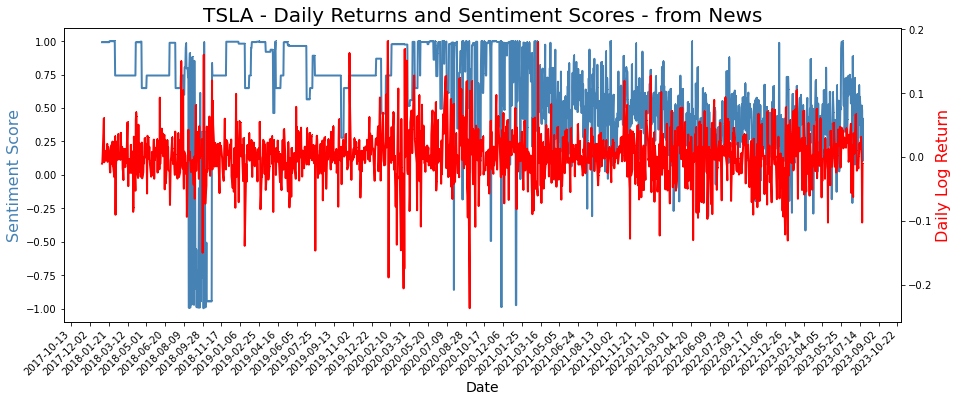

In [26]:
plot_sentiment_graph("TSLA - Daily Returns and Sentiment Scores - from News", scores_df, stock_df, 50, mark = ',', width = 2)